# Imports

In [1]:
import os
from os import walk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import testing.FeetsForTESS.FFTESS as FFTSS
from sklearn.utils import Bunch
import pylab as pl

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn import neighbors
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import joblib

# Load Data

In [ ]:
def load_data():
    f = []

    for (dirpath, dirnames, filenames) in walk("..\\_TESS_lightcurves_outliercleaned"):
        for filename in filenames:
            full_path = os.path.join(dirpath, filename)
            pathTittle = full_path.split(os.sep)
            step = []
            step.append(full_path)
            step.append(pathTittle[-2])
            step.append(pathTittle[-1])
            f.append(step)
    
    return f

In [3]:
f = load_data()
categories = []
for i in range(len(f)):
    if str(f[i][1]).startswith("E"):
        holder = [f[i][1], 'Eclipsing']
        if holder not in categories:
                categories.append(holder)
    elif str(f[i][1]).startswith("A") or str(f[i][1]).startswith("RO") or str(f[i][1]).startswith("RS"):
        holder = [f[i][1], 'Rotating']
        if holder not in categories:
                categories.append(holder)
    else:
        holder = [f[i][1], 'Pulsating']
        if holder not in categories:
             categories.append(holder)

# Work

## First Calc

In [10]:
from astropy.timeseries import LombScargle

In [11]:
def periodogram(t, y, dy):
    # Periodograma Lomb-Scargle
    time_range = t.max() - t.min()
    ls = LombScargle(t, y, dy)
    minfreq = 1 / (time_range*1.5)

    freq, power = ls.autopower(nyquist_factor=1, minimum_frequency=minfreq)
    periods = 1 / freq
    best_period = periods[np.argmax(power)]

    return best_period

In [12]:
i = 0
j = 0
total = []
catinxd = []
subcatinxd = []
cats = []
subcats = []
while j < len(categories):
    subcats.append(categories[j][0])
    
    if categories[j][1] not in cats:
        cats.append(categories[j][1])

    while i < len(f) and f[i][1] == categories[j][0]:
        data = pd.read_csv(f[i][0], delimiter=",", names=["JD", "MAG", "ERR"], na_values="*********")
        time = data["JD"]
        mag = data["MAG"]
        error = data["ERR"]
        
        aux = []
        
        aux.append(FFTSS.amplitude(mag))
        aux.append(FFTSS.beyond1_std(mag, error))
        aux.append(FFTSS.medianabsdev(mag))

        aux.append(FFTSS.med_BRP(mag))
        aux.append(FFTSS.per_amplitude(mag))
        aux.append(FFTSS.PDFP(mag))

        aux.append(FFTSS.tess_rcs(mag))
        aux.append(FFTSS.smallkurtosis(mag))
        aux.append(FFTSS.maxslope(time, mag))

        aux.append(FFTSS.simple_functions.tess_std(mag))
        aux.append(FFTSS.simple_functions.lineartrend(time, mag))
        aux.append(FFTSS.simple_functions.mean(mag))

        aux.append(FFTSS.Gskew(mag))
        aux.append(FFTSS.simple_functions.mean_v(mag))
        aux.append(FFTSS.simple_functions.tess_skew(mag))

        aux.append(periodogram(time, mag, error))

        total.append(aux)

        subcatinxd.append(j)
        catinxd.append(cats.index(categories[j][1]))
        i += 1
    j += 1

## Do dictionary

In [13]:
totalaux = total

In [14]:
# Preprocess Dictionary:
sample = pd.read_csv(f[0][0], delimiter=",", names=["JD", "MAG", "ERR"], na_values="*********")
limited = int((max(sample['JD']) - min(sample['JD'])) * 10) / 10

indexes = []
for i in range(len(totalaux)):
    if totalaux[i][15] > limited:
        indexes.append(i)
        
indexes.reverse()

for i in range(len(indexes)):
    totalaux.pop(indexes[i])
    catinxd.pop(indexes[i])
    subcatinxd.pop(indexes[i])

In [15]:

data = np.array(total)
maintarget = np.array(catinxd)
maintargetnames = np.array(cats, dtype='<U10')
subtarget = np.array(subcatinxd)
subtargetnames = np.array(subcats, dtype='<U10')
featuresnames = np.array(['amplitude','beyond1_std','median abs dev','median BRP','percent amplitude','percent diff flux percentile',
                 'rcs','small kurtosis','max slopes','std','linear trend', 'mean', 'gskew', 'meanv',
                 'skew'], dtype='<U10')

In [19]:
mydict = {}
mydict['data'] = data
mydict['main_target'] = maintarget
mydict['main_target_names'] = maintargetnames
mydict['sub_target'] = subtarget
mydict['sub_target_names'] = subtargetnames
mydict['features_names'] = featuresnames

In [20]:
lcs = Bunch(**mydict)

### Save Dict

In [21]:
joblib.dump(lcs, "TESS_Dict.pkl")

['TESS_Dict.pkl']

## Special Function

In [67]:
import seaborn as sns


def to_density(cf):
  '''
  This function will take in a confusion matrix cf and return the relative 'density' of every element in each row.
  ---------
  cf: Confusion matrix to be passed in
  '''
  density = []
  n, k = cf.shape
  for i in range(n):
    density_row = []
    for j in range(k):
      total_stars = sum(cf[i])
      density_row.append(cf[i][j]/total_stars)
    density.append(density_row)
  return np.array(density)


def make_confusion_matrix(cf_,
                          xlabel, ylabel,
                          group_names=None,
                          categories='auto',
                          count=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          ):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf_:            Confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''

    cf = to_density(cf_)
    
    # Generate the labels for the matrix elements:
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.2f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_labels,group_counts)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # Set figure paramaters:
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # Make the heatmap:
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,yticklabels=categories)

    if xyplotlabels:
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

    if title:
        plt.title(title)

## ML

In [62]:
X, y = lcs.data, lcs.target
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(120,), max_iter=1000, random_state=42, activation='tanh')
clf = LogisticRegression(max_iter=1000, random_state=42, solver='newton-cg')
rforest = RandomForestClassifier(n_estimators=100, random_state=42)

### MLP

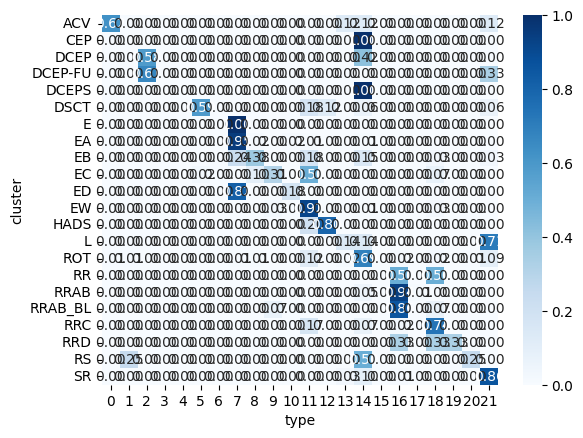

In [78]:
mlp.fit(Xtrain, ytrain)
y_pred = mlp.predict(Xtest)
make_confusion_matrix(confusion_matrix(ytest, y_pred), xlabel="type", ylabel="cluster", categories=lcs.target_names, count=True)

### CLF

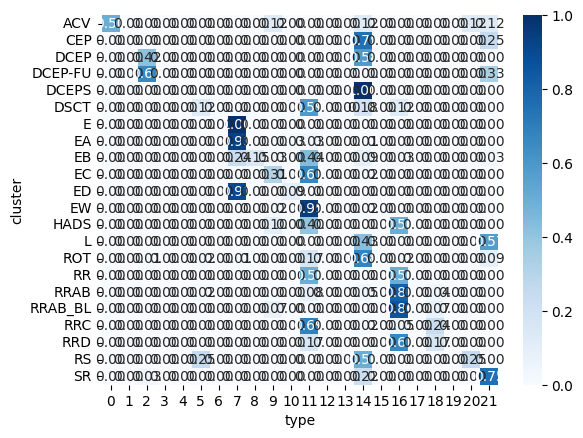

In [79]:
clf.fit(Xtrain, ytrain)
y_pred_CLF = clf.predict(Xtest)
make_confusion_matrix(confusion_matrix(ytest, y_pred_CLF), xlabel="type", ylabel="cluster", categories=lcs.target_names, count=True)

### Random Forest

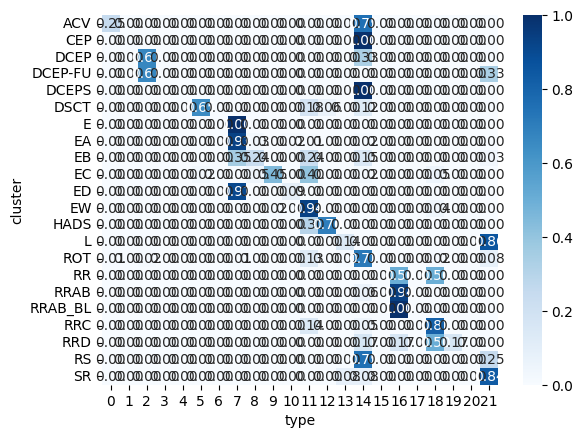

In [80]:
rforest.fit(Xtrain, ytrain)
y_pred_rforest = rforest.predict(Xtest)
make_confusion_matrix(confusion_matrix(ytest, y_pred_rforest), xlabel="type", ylabel="cluster", categories=lcs.target_names, count=True)

## ML with Kfold

In [15]:
X, y = lcs.data, lcs.target
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [57]:
mlp = MLPClassifier(hidden_layer_sizes=(120,), max_iter=1000, random_state=42, activation='tanh')

clf = LogisticRegression(max_iter=1000, random_state=42, solver='newton-cg')

rforest = RandomForestClassifier(n_estimators=100, random_state=42)

In [58]:
scoresMLP = cross_val_score(mlp, X, y, cv=kfold)

In [26]:
scoresCLF = cross_val_score(clf, X, y, cv=kfold)

In [28]:
scoresRF = cross_val_score(rforest, X, y, cv=kfold)

In [59]:
print("MLP      Media:", scoresMLP.mean(), "standar:", scoresMLP.std())
print("CLF      Media:", scoresCLF.mean(), "standar:", scoresCLF.std())
print("FOREST   Media:", scoresRF.mean(), "standar:", scoresRF.std())

MLP      Media: 0.7656146130444608 standar: 0.014322116703497176
CLF      Media: 0.6914029164524463 standar: 0.001934576931606398
FOREST   Media: 0.7748207917582219 standar: 0.011495673858618697
